# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier **DONE**
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. **DONE**
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing. **DONE**
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images. **DONE**
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles. **DONE**
* Estimate a bounding box for vehicles detected. **DONE**

In [1]:
import glob
import time

import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.misc import imresize
from skimage.feature import hog
from skimage.io import imread
from skimage.exposure import adjust_gamma
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
%matplotlib inline

## HOG

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a img
# Have this function call bin_spatial() and color_hist()
def features_for_vis(image, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    
    if hog_channel == 'ALL':
        hog_features = []
        hog_images = []
        for channel in range(feature_image.shape[2]):
            feats, images = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=True)
            hog_features.append(feats)
            hog_images.append(images)
        hog_features = np.ravel(hog_features) 
    else:
        hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    return hog_features, hog_images


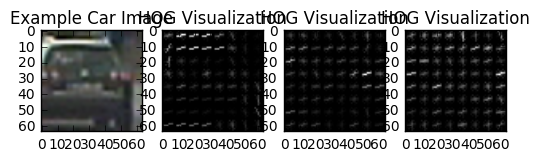

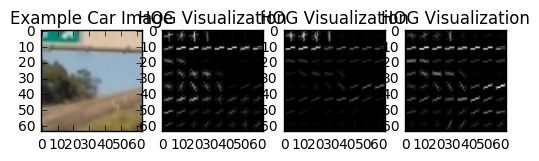

In [3]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Check the HOG extraction

cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

random_index = np.random.randint(0, len(cars))

img = cars[random_index]
features, hog_image = features_for_vis(mpimg.imread(img), cspace=cspace, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

fig = plt.figure()
plt.subplot(1, len(hog_image)+1, 1)
plt.imshow(mpimg.imread(img))
plt.title('Example Car Image')
for idx, hog_img in enumerate(hog_image):
  plt.subplot(1, len(hog_image)+1, idx+2)
  plt.imshow(hog_img, cmap='gray')
  plt.title('HOG Visualization')
  
  
img = notcars[random_index]
features, hog_image = features_for_vis(mpimg.imread(img), cspace=cspace, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

fig = plt.figure()
plt.subplot(1, len(hog_image)+1, 1)
plt.imshow(mpimg.imread(img))
plt.title('Example Car Image')
for idx, hog_img in enumerate(hog_image):
  plt.subplot(1, len(hog_image)+1, idx+2)
  plt.imshow(hog_img, cmap='gray')
  plt.title('HOG Visualization')

## FEATURE EXTRACTION

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
  
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features  


### FEATURE PARAMS

In [5]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
# Build the datasets

cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

car_features = extract_features(cars, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
 

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    

# Remove NaN
#X[np.isnan(X)] = np.median(X[~np.isnan(X)])

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)  

print('Using:',cspace,'cspace',hog_channel,'hog_channel')
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## Training phase
- Support Vector Machine

In [ ]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

### Save the weights

In [ ]:
joblib.dump(svc, 'svc.pkl')
joblib.dump(X_scaler, 'scaler.pkl')
print('Done')

## CHECKPOINT

In [6]:
svc = joblib.load('svc.pkl')
X_scaler = joblib.load('scaler.pkl')
print('Done')

Done


##  Sliding-window technique

In [7]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
  
def convert_image_color(img):
  if cspace != 'RGB':
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
  else: feature_image = np.copy(img)      
  return feature_image

## Heatmap

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Checking algorithm

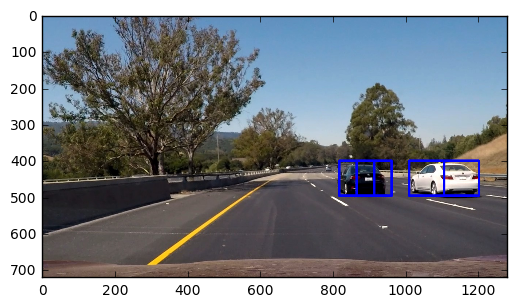

In [9]:
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

y_start_stop=[400,700]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


## Heatmap on images

In [10]:
window_configs = [
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (256, 256),
    "xy_overlap": (0.5, 0.5)
  },
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (128, 128),
    "xy_overlap": (0.6, 0.5)
  },
  {
    "x_start_stop": [100, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (96, 96),
    "xy_overlap": (0.7, 0.5)
  },
  {
    "x_start_stop": [500, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (48, 48),
    "xy_overlap": (0.7, 0.5)
  }
]

def process_image_heatmap(img):
  
  image = mpimg.imread(img)
  image = image.astype(np.float32)/255
  
  draw_image = mpimg.imread(img)

  heat = np.zeros_like(image[:,:,0]).astype(np.float)
  
  all_windows = []
  
  for window_config in window_configs:
        
    x_start_stop = window_config.get('x_start_stop')
    y_start_stop = window_config.get('y_start_stop')
    xy_window = window_config.get('xy_window')
    xy_overlap = window_config.get('xy_overlap')
      
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                      xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)   
    
    for window in hot_windows:
      all_windows.append(window)
  
  # Add heat to each box in box list
  heat = add_heat(heat,all_windows)

  # Apply threshold to help remove false positives
  heat = apply_threshold(heat,1)

  # Visualize the heatmap when displaying    
  heatmap = np.clip(heat, 0, 255)

  # Find final boxes from heatmap using label function
  labels = label(heatmap)
  draw_image = draw_labeled_bboxes(draw_image, labels)
  
  return draw_image, heatmap


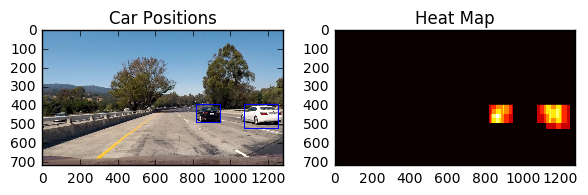

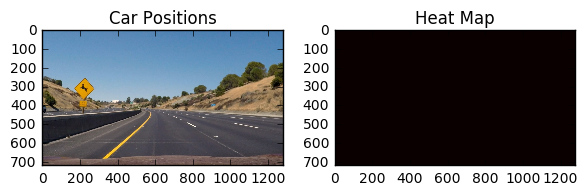

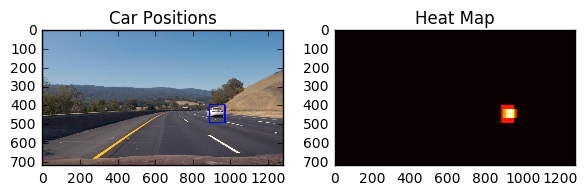

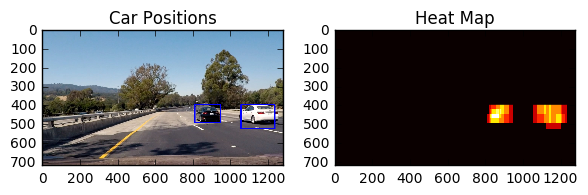

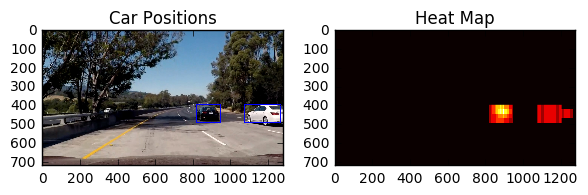

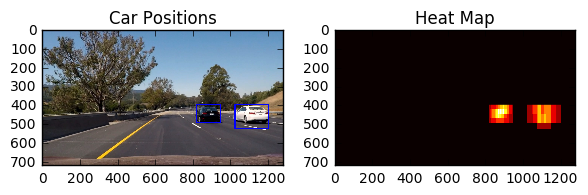

In [11]:
for img in glob.glob('./test_images/*.jpg'):
  
    draw_img, heatmap = process_image_heatmap(img);

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

## Video processing

In [13]:
window_configs = [
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (256, 256),
    "xy_overlap": (0.5, 0.5)
  },
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (128, 128),
    "xy_overlap": (0.6, 0.5)
  },
  {
    "x_start_stop": [100, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (96, 96),
    "xy_overlap": (0.7, 0.5)
  },
  {
    "x_start_stop": [500, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (48, 48),
    "xy_overlap": (0.7, 0.5)
  }
]

class Video(object):
  
  def __init__(self):
    self.frame_count = 0
    self.last_labels = None

  def update(self):
    self.frame_count += 1
    

def process_video(img):
  
  video.update()
  
  image = img
  image = image.astype(np.float32)/255
  draw_image = np.copy(img)

  if video.frame_count == 1 or video.frame_count % 5 == 0:
  
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    all_windows = []

    for window_config in window_configs:

      x_start_stop = window_config.get('x_start_stop')
      y_start_stop = window_config.get('y_start_stop')
      xy_window = window_config.get('xy_window')
      xy_overlap = window_config.get('xy_overlap')

      windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

      hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)   

      for window in hot_windows:
        all_windows.append(window)

    heat = add_heat(heat,all_windows)
    heat = apply_threshold(heat,1)
    labels = label(heat)
    video.last_labels = labels
    draw_image = draw_labeled_bboxes(draw_image, labels)
    return draw_image
  
  else:
    draw_image = draw_labeled_bboxes(draw_image, video.last_labels)
    return draw_image


In [14]:
video = Video()
output = 'result.mp4'
clip1 = VideoFileClip("./test_videos/test_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 8.93 s, sys: 341 ms, total: 9.27 s
Wall time: 11 s


In [15]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [16]:
video = Video()
output = 'result.mp4'
clip1 = VideoFileClip("./test_videos/project_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [05:53<00:00,  2.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 5min 18s, sys: 12.7 s, total: 5min 31s
Wall time: 5min 55s


In [17]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [18]:
video = Video()
output = 'result4.mp4'
clip1 = VideoFileClip("./test_videos/project4_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result4.mp4
[MoviePy] Writing video result4.mp4


100%|█████████▉| 1260/1261 [06:08<00:00,  2.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result4.mp4 

CPU times: user 5min 25s, sys: 13.6 s, total: 5min 39s
Wall time: 6min 9s


In [19]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result4.mp4'))